In [1]:
import os
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.linear_model import ElasticNetCV
from sklearn.preprocessing import StandardScaler
from statsmodels.formula.api import ols
from statsmodels.stats.multitest import multipletests
from itertools import combinations

warnings.filterwarnings('ignore')

sns.set(style='whitegrid', palette='viridis')
plt.rcParams.update({
    'font.family': 'Arial',
    'font.size': 12,
    'axes.titlesize': 16,
    'axes.labelsize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'savefig.dpi': 300,
    'savefig.bbox': 'tight',
    'savefig.transparent': False,
    'figure.facecolor': 'white',
    'axes.facecolor': 'white'
})

output_path = r"D:\liverbrain\1part\results"
os.makedirs(output_path, exist_ok=True)

# 读取数据
data_file_path = r"D:\liverbrain\1part\OHEselected3child.csv"
data = pd.read_csv(data_file_path, index_col=0)

# 转换sex和Child为分类变量
data['sex'] = data['sex'].astype('category')
data['Child'] = data['Child'].astype('category')

# 生成哑变量，sex只生成一个（drop_first），Child全部保留（不drop_first）
data_encoded = pd.get_dummies(
    data, 
    columns=['sex'],
    drop_first=True,
    prefix_sep='_'
)
# Child为有序三分类变量，全部保留，不drop_first
child_dummies = pd.get_dummies(data['Child'], prefix='Child', drop_first=False)
data_encoded = pd.concat([data_encoded, child_dummies], axis=1)

# 标识有效特征列
def is_valid_feature(col):
    return col != 'Pallidal_Index' and data_encoded[col].dtype in [np.float64, np.int64]

all_features = [col for col in data_encoded.columns if is_valid_feature(col)]
clinical_vars = ['age', 'PLT', 'ALB', 'TBIB', 'ALT', 'AST', 'PT', 'APTT', 'TT', 'FIB', 'DD']
morphology_vars = [col for col in all_features if col.startswith('original') or 'Curv' in col]

# 标准化连续变量
scaler = StandardScaler()
to_scale = list(set(clinical_vars + morphology_vars) & set(all_features))
data_encoded[to_scale] = scaler.fit_transform(data_encoded[to_scale])

# 相关性分析函数（使用FDR校正）
def enhanced_correlation_analysis(df, target, clinical_vars, morphology_vars, alpha=0.05):
    results = []
    # 连续变量
    for var in clinical_vars + morphology_vars:
        if var in df.columns:
            corr, pval = stats.spearmanr(df[var], df[target])
            results.append({
                'Variable': var,
                'Type': 'Morphology' if var in morphology_vars else 'Clinical',
                'Correlation': corr,
                'P-value': pval,
                'Method': 'Spearman'
            })
    # 分类变量（sex_1）
    if 'sex_1' in df.columns:
        group1 = df[df['sex_1'] == 1][target]
        group0 = df[df['sex_1'] == 0][target]
        if len(group1) > 0 and len(group0) > 0:
            f_val, p_val = stats.f_oneway(group1, group0)
            pooled_std = np.sqrt((group1.std()**2 + group0.std()**2) / 2)
            d = (group1.mean() - group0.mean()) / pooled_std
            results.append({
                'Variable': 'sex_1',
                'Type': 'Categorical',
                'F-value': f_val,
                'P-value': p_val,
                'Effect Size': d,
                'Method': 'ANOVA'
            })
    # 分类变量（Child_1, Child_2, Child_3）
    child_vars = [col for col in df.columns if col.startswith('Child_')]
    if len(child_vars) >= 2:  # 至少两个分组
        groups = [df[df[col] == 1][target] for col in child_vars]
        if all(len(g) > 0 for g in groups):
            f_val, p_val = stats.f_oneway(*groups)
            ss_between = sum([len(g) * (g.mean() - df[target].mean())**2 for g in groups])
            ss_total = sum((df[target] - df[target].mean())**2)
            eta_sq = ss_between / ss_total if ss_total > 0 else np.nan
            results.append({
                'Variable': 'Child_group',
                'Type': 'Categorical',
                'F-value': f_val,
                'P-value': p_val,
                'Effect Size': eta_sq,
                'Method': 'ANOVA'
            })
        for col in child_vars:
            corr, pval = stats.pointbiserialr(df[col], df[target])
            results.append({
                'Variable': col,
                'Type': 'Categorical',
                'Correlation': corr,
                'P-value': pval,
                'Method': 'pointbiserial'
            })
    if not results:
        return pd.DataFrame()
    results_df = pd.DataFrame(results)
    # 仅 FDR 校正
    pvals = results_df['P-value'].values
    _, pvals_fdr, _, _ = multipletests(pvals, alpha=alpha, method='fdr_bh')
    results_df['P-value (FDR)'] = pvals_fdr
    return results_df

# 新增：科学标注星号
def pval_to_star(pv):
    if pv < 0.001:
        return '***'
    elif pv < 0.01:
        return '**'
    elif pv < 0.05:
        return '*'
    else:
        return 'ns'

# 修改Child组箱线图函数带显著性标注
def plot_boxplot(data, var, target, output_path, prefix):
    plt.figure(figsize=(8, 6))
    if var == 'sex_1':
        data['sex_plot'] = data['sex_1'].map({0: 'Female', 1: 'Male'})
        sns.boxplot(x='sex_plot', y=target, data=data, palette="Set2")
        plt.xlabel("Sex")
    elif var.startswith('Child_'):
        # 定义映射关系
        child_label_map = {
            '1': 'Child-Pugh A',
            '2': 'Child-Pugh B',
            '3': 'Child-Pugh C'
        }
        # 还原为 Child 原始分组
        child_vars = [col for col in data.columns if col.startswith('Child_')]
        # 记录idxmax前的顺序
        ordered_child_vars = sorted(child_vars, key=lambda x: int(x.split('_')[1]))
        child_labels = [child_label_map.get(col.split('_')[1], col) for col in ordered_child_vars]
        data['Child_plot'] = data[ordered_child_vars].idxmax(axis=1).apply(lambda x: child_label_map.get(x.split('_')[1], x))
        # 箱线图绘制
        ax = sns.boxplot(x='Child_plot', y=target, data=data, palette="Set3", order=child_labels)
        plt.xlabel("Child-Pugh Score")
        plt.title("Child-Pugh Score vs. PI")
        # 统计学检验&标注
        group_vals = {}
        for label, orig_col in zip(child_labels, ordered_child_vars):
            group_vals[label] = data[data[orig_col]==1][target].dropna().values
        pairs = list(combinations(child_labels, 2))
        y_max = max([np.max(vals) if len(vals) > 0 else 0 for vals in group_vals.values()])
        y_min = min([np.min(vals) if len(vals) > 0 else 0 for vals in group_vals.values()])
        h = (y_max - y_min) * 0.07 if y_max != y_min else 1
        v_offset = y_max + h
        for idx, (g1, g2) in enumerate(pairs):
            # 非参数检验
            try:
                u_stat, pval = stats.mannwhitneyu(group_vals[g1], group_vals[g2], alternative='two-sided')
            except Exception:
                pval = 1.0
            star = pval_to_star(pval)
            x1, x2 = child_labels.index(g1), child_labels.index(g2)
            line_y = v_offset + idx * h
            # 画线和p值/星号
            ax.plot([x1, x1, x2, x2], [line_y, line_y+h/4, line_y+h/4, line_y], c='k', linewidth=1)
            text = star if star != 'ns' else f"p={pval:.2g}"
            ax.text((x1+x2)/2, line_y+h/3, text, ha='center', va='bottom', fontsize=13, color='k')
        plt.ylabel(target)
    else:
        return
    plt.tight_layout()
    plt.savefig(os.path.join(output_path, f"{prefix}_boxplot_{var}.png"))
    plt.close()
    # 删除临时列
    if 'sex_plot' in data.columns:
        data.drop(columns=['sex_plot'], inplace=True)
    if 'Child_plot' in data.columns:
        data.drop(columns=['Child_plot'], inplace=True)

# 相关性分析
corr_results = enhanced_correlation_analysis(
    data_encoded, 'Pallidal_Index', clinical_vars, morphology_vars
)
corr_results.to_csv(os.path.join(output_path, "enhanced_correlation_results.csv"), index=False)

# 相关性热图（仅FDR校正显著特征）
plt.figure(figsize=(18, 14))
sig_vars_fdr = corr_results[corr_results['P-value (FDR)'] < 0.05]['Variable'].tolist()
if not sig_vars_fdr:
    sig_vars_fdr = corr_results.sort_values('P-value').head(10)['Variable'].tolist()  # 保底补全
sig_vars_fdr = [v for v in sig_vars_fdr if v in data_encoded.columns]

heatmap_vars = list(set(sig_vars_fdr + ['Pallidal_Index']) & set(data_encoded.columns))
if len(heatmap_vars) > 1:
    corr_matrix = data_encoded[heatmap_vars].corr(method='spearman')
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    sns.heatmap(corr_matrix, mask=mask, cmap='coolwarm', vmin=-1, vmax=1, 
                annot=True, fmt=".2f", square=True, linewidths=.5, annot_kws={"size": 8})
    plt.title("Spearman Correlation Heatmap (FDR Significant Variables)")
    plt.tight_layout()
    plt.savefig(os.path.join(output_path, "correlation_heatmap_fdr.png"))
    plt.close()

# 第一次回归分析（基于FDR校正显著特征）
if len(sig_vars_fdr) >= 2:
    formula_fdr = f"Pallidal_Index ~ {' + '.join(sig_vars_fdr)}"
    model_fdr = ols(formula_fdr, data=data_encoded).fit()
    with open(os.path.join(output_path, "regression_summary_fdr.txt"), "w") as f:
        f.write("=== 基于FDR校正有意义特征的多元回归分析 ===\n")
        f.write(f"样本量: {len(data_encoded)}\n")
        f.write(f"回归方程: {formula_fdr}\n\n")
        f.write(model_fdr.summary().as_text())
    std_y = data_encoded['Pallidal_Index'].std()
    std_x = data_encoded[sig_vars_fdr].std()
    beta_std_fdr = pd.DataFrame({
        'Variable': sig_vars_fdr,
        'Raw_Coefficient': model_fdr.params[1:].values,
        'Std_Error': model_fdr.bse[1:].values,
        'P_value': model_fdr.pvalues[1:].values,
        'Standardized_Coefficient': model_fdr.params[1:].values * std_x.values / std_y
    })
    beta_std_fdr.to_csv(os.path.join(output_path, "standardized_coefficients_fdr.csv"), index=False)
    # 显著回归系数图
    beta_std_sig_fdr = beta_std_fdr[beta_std_fdr['P_value'] < 0.05]
    if not beta_std_sig_fdr.empty:
        plt.figure(figsize=(12, 7))
        beta_plot = beta_std_sig_fdr.sort_values('Standardized_Coefficient', ascending=False)
        sns.barplot(x='Standardized_Coefficient', y='Variable', data=beta_plot, 
                    palette=['red' if x < 0 else 'blue' for x in beta_plot['Standardized_Coefficient']])
        plt.title("Standardized Regression Coefficients (FDR Selected Variables)")
        plt.xlabel("Standardized Coefficient")
        plt.ylabel("Variables")
        plt.axvline(x=0, color='black', linestyle='--')
        plt.tight_layout()
        plt.savefig(os.path.join(output_path, "regression_coefficients_fdr.png"))
        plt.close()

    # 画多元回归有统计学意义自变量与因变量的图像
    for var in beta_std_sig_fdr['Variable']:
        if var == 'sex_1' or var.startswith('Child_'):
            plot_boxplot(data_encoded, var, 'Pallidal_Index', output_path, prefix='regression_fdr')
        else:
            plt.figure(figsize=(8, 6))
            ax = plt.gca()
            sns.scatterplot(x=data_encoded[var], y=data_encoded['Pallidal_Index'], ax=ax)
            sns.regplot(x=data_encoded[var], y=data_encoded['Pallidal_Index'], ax=ax, 
                        scatter=False, color='red', line_kws={'lw':2})
            reg_beta = model_fdr.params[var] if var in model_fdr.params else np.nan
            reg_p = model_fdr.pvalues[var] if var in model_fdr.pvalues else np.nan
            plt.title(
                f"{var} vs Pallidal_Index\n"
                f"β={reg_beta:.2f}, P={reg_p:.3g}"
            )
            plt.xlabel(var)
            plt.ylabel('Pallidal_Index')
            plt.tight_layout()
            plt.savefig(os.path.join(output_path, f"regression_scatter_fdr_{var}.png"))
            plt.close()

# 弹性网络分析（输入使用FDR显著特征）
X = data_encoded[sig_vars_fdr]
y = data_encoded['Pallidal_Index']
enet = ElasticNetCV(
    l1_ratio=[.1, .3, .5, .7, .9, .95, 1],
    alphas=np.logspace(-4, 1, 50),
    cv=5, random_state=42, max_iter=10000
)
enet.fit(X, y)
enet_df = pd.DataFrame({
    'Variable': X.columns,
    'Coefficient': enet.coef_,
    'Absolute_Importance': np.abs(enet.coef_),
    'Selected': enet.coef_ != 0
}).sort_values('Absolute_Importance', ascending=False)
enet_df.to_csv(os.path.join(output_path, "elastic_net_results.csv"), index=False)

# 变量重要性可视化
plt.figure(figsize=(12, 8))
selected_vars_enet = enet_df[enet_df['Selected']]
if not selected_vars_enet.empty:
    sns.barplot(
        x='Absolute_Importance', 
        y='Variable', 
        data=selected_vars_enet.head(10),
        palette='viridis'
    )
    plt.title("Top 10 Important Variables (Elastic Net)")
    plt.xlabel("Absolute Coefficient Value")
    plt.tight_layout()
    plt.savefig(os.path.join(output_path, "feature_importance_enet.png"))
    plt.close()

# 第二次回归分析（基于弹性网络显著特征）
sig_vars_enet = enet_df[enet_df['Selected']]['Variable'].tolist()

if len(sig_vars_enet) >= 2:
    formula_enet = f"Pallidal_Index ~ {' + '.join(sig_vars_enet)}"
    model_enet = ols(formula_enet, data=data_encoded).fit()
    with open(os.path.join(output_path, "regression_summary_enet.txt"), "w") as f:
        f.write("=== 基于弹性网络有意义特征的多元回归分析 ===\n")
        f.write(f"样本量: {len(data_encoded)}\n")
        f.write(f"回归方程: {formula_enet}\n\n")
        f.write(model_enet.summary().as_text())
    std_y = data_encoded['Pallidal_Index'].std()
    std_x = data_encoded[sig_vars_enet].std()
    beta_std_enet = pd.DataFrame({
        'Variable': sig_vars_enet,
        'Raw_Coefficient': model_enet.params[1:].values,
        'Std_Error': model_enet.bse[1:].values,
        'P_value': model_enet.pvalues[1:].values,
        'Standardized_Coefficient': model_enet.params[1:].values * std_x.values / std_y
    })
    beta_std_enet.to_csv(os.path.join(output_path, "standardized_coefficients_enet.csv"), index=False)
    # 显著回归系数图
    beta_std_sig_enet = beta_std_enet[beta_std_enet['P_value'] < 0.05]
    if not beta_std_sig_enet.empty:
        plt.figure(figsize=(12, 7))
        beta_plot = beta_std_sig_enet.sort_values('Standardized_Coefficient', ascending=False)
        sns.barplot(x='Standardized_Coefficient', y='Variable', data=beta_plot, 
                    palette=['red' if x < 0 else 'blue' for x in beta_plot['Standardized_Coefficient']])
        plt.title("Standardized Regression Coefficients (Elastic Net Selected Variables)")
        plt.xlabel("Standardized Coefficient")
        plt.ylabel("Variables")
        plt.axvline(x=0, color='black', linestyle='--')
        plt.tight_layout()
        plt.savefig(os.path.join(output_path, "regression_coefficients_enet.png"))
        plt.close()

    # 画多元回归有统计学意义自变量与因变量的图像
    for var in beta_std_sig_enet['Variable']:
        if var == 'sex_1' or var.startswith('Child_'):
            plot_boxplot(data_encoded, var, 'Pallidal_Index', output_path, prefix='regression_enet')
        else:
            plt.figure(figsize=(8, 6))
            ax = plt.gca()
            sns.scatterplot(x=data_encoded[var], y=data_encoded['Pallidal_Index'], ax=ax)
            sns.regplot(x=data_encoded[var], y=data_encoded['Pallidal_Index'], ax=ax, 
                        scatter=False, color='red', line_kws={'lw':2})
            reg_beta = model_enet.params[var] if var in model_enet.params else np.nan
            reg_p = model_enet.pvalues[var] if var in model_enet.pvalues else np.nan
            plt.title(
                f"{var} vs Pallidal_Index\n"
                f"β={reg_beta:.2f}, P={reg_p:.3g}"
            )
            plt.xlabel(var)
            plt.ylabel('Pallidal_Index')
            plt.tight_layout()
            plt.savefig(os.path.join(output_path, f"regression_scatter_enet_{var}.png"))
            plt.close()

# 综合结果报告
with open(os.path.join(output_path, "analysis_summary.txt"), "w") as f:
    f.write("肝硬化患者Pallidal指数分析报告\n")
    f.write("=" * 50 + "\n\n")
    f.write("1. 描述性统计:\n")
    f.write(f"   总样本量: {len(data_encoded)}\n")
    f.write(f"   Pallidal指数均值: {data_encoded['Pallidal_Index'].mean():.2f}\n")
    f.write(f"   Pallidal指数标准差: {data_encoded['Pallidal_Index'].std():.2f}\n\n")
    f.write("2. 相关性分析（FDR校正）:\n")
    sig_vars_fdr_report = corr_results[corr_results['P-value (FDR)'] < 0.05]
    f.write(f"   FDR校正后显著相关变量数量: {len(sig_vars_fdr_report)}\n")
    for _, row in sig_vars_fdr_report.iterrows():
        f.write(f"   {row['Variable']}: 相关性={row.get('Correlation', np.nan):.2f}, P值={row['P-value']:.4f}\n")
    f.write("\n3. 基于FDR校正有意义特征的回归分析:\n")
    if len(sig_vars_fdr) >= 2:
        f.write(f"   使用的特征: {', '.join(sig_vars_fdr)}\n")
        f.write(f"   R-squared: {model_fdr.rsquared:.4f}\n")
        f.write(f"   Adjusted R-squared: {model_fdr.rsquared_adj:.4f}\n")
    else:
        f.write("   没有足够的特征进行回归分析。\n")
    f.write("\n4. 弹性网络分析:\n")
    f.write(f"   选中的特征数量: {len(selected_vars_enet)}\n")
    for _, row in selected_vars_enet.iterrows():
        f.write(f"   {row['Variable']}: 系数={row['Coefficient']:.4f}\n")
    f.write("\n5. 基于弹性网络有意义特征的回归分析:\n")
    if len(sig_vars_enet) >= 2:
        f.write(f"   使用的特征: {', '.join(sig_vars_enet)}\n")
        f.write(f"   R-squared: {model_enet.rsquared:.4f}\n")
        f.write(f"   Adjusted R-squared: {model_enet.rsquared_adj:.4f}\n")
    else:
        f.write("   没有足够的特征进行回归分析。\n")

print(f"分析成功完成！结果保存至: {output_path}")

分析成功完成！结果保存至: D:\liverbrain\1part\results


Optimization terminated successfully.
         Current function value: 0.507151
         Iterations 8


C:\Users\15961\AppData\Local\Temp\ipykernel_41452\3002579871.py:35: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  or_value = np.exp(result_multivariate.params[i+1])
C:\Users\15961\AppData\Local\Temp\ipykernel_41452\3002579871.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = result_multivariate.pvalues[i+1]
C:\Users\15961\AppData\Local\Temp\ipykernel_41452\3002579871.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  

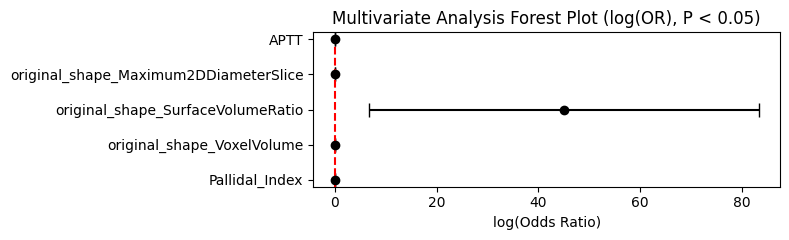

In [1]:
import pandas as pd
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
import os

# 读取数据
data = pd.read_csv('D:/liverbrain/1part/selectedall.csv')

# 假设第一列为ID，最后一列为因变量，其他列为自变量
id_col = data.columns[0]
y_col = data.columns[-1]
X_cols = data.columns[1:-1]

# 因变量
y = data[y_col]

# 自变量
X = data[X_cols]

# 创建目录以保存结果
output_dir = 'D:/liverbrain/1part/results2'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# 多因素Logistic回归分析
X_multivariate = sm.add_constant(X)
model_multivariate = sm.Logit(y, X_multivariate)
result_multivariate = model_multivariate.fit()

# 提取多因素分析的OR、95% CI和p值
multivariate_results = []
for i, col in enumerate(X_cols):
    ci = result_multivariate.conf_int().loc[col]
    or_value = np.exp(result_multivariate.params[i+1])
    p_value = result_multivariate.pvalues[i+1]
    # 新增: 取log(OR)和log(CI)
    log_or = result_multivariate.params[i+1]
    log_ci_lower = ci[0]
    log_ci_upper = ci[1]
    multivariate_results.append({
        'variable': col,
        'OR': or_value,
        'CI_lower': np.exp(ci[0]),
        'CI_upper': np.exp(ci[1]),
        'p_value': p_value,
        'log_OR': log_or,
        'log_CI_lower': log_ci_lower,
        'log_CI_upper': log_ci_upper
    })

# 转换为DataFrame
multivariate_df = pd.DataFrame(multivariate_results)

# 保存多因素分析结果
multivariate_df.to_csv(os.path.join(output_dir, 'multivariate_analysis_results.csv'), index=False)

# 只保留p值小于0.05的特征
significant_df = multivariate_df[multivariate_df['p_value'] < 0.05]

if significant_df.empty:
    print("没有 p < 0.05 的显著特征，无法绘制森林图。")
else:
    # 绘制 log(OR) 森林图
    plt.figure(figsize=(8, len(significant_df) * 0.5))

    plt.errorbar(
        significant_df['log_OR'], range(len(significant_df)),
        xerr=[
            significant_df['log_OR'] - significant_df['log_CI_lower'],
            significant_df['log_CI_upper'] - significant_df['log_OR']
        ],
        fmt='o', color='black', capsize=5
    )
    plt.yticks(range(len(significant_df)), significant_df['variable'])
    plt.axvline(x=0, color='red', linestyle='--')  # 在log(OR)=0处画线
    plt.xlabel('log(Odds Ratio)')
    plt.title('Multivariate Analysis Forest Plot (log(OR), P < 0.05)')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'multivariate_log_forest_plot.png'))
    plt.show()